<a href="https://colab.research.google.com/github/hafsaimranattaria71125/Ring_matcher/blob/main/ring_match_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Clean folders
!rm -rf /content/ring_matcher
!mkdir -p /content/ring_matcher/data/ab_jewellers/images

# 2. CPU-Specific installs (Fast & Light)
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install git+https://github.com/facebookresearch/segment-anything.git

# 3. Real-ESRGAN without the 'Basicsr' headache
!pip install basicsr --no-deps
!pip install gfpgan facexlib
!pip install git+https://github.com/xinntao/Real-ESRGAN.git@v0.3.0

Looking in indexes: https://download.pytorch.org/whl/cpu
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n35f1lbq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n35f1lbq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/xinntao/Real-ESRGAN.git (to revision v0.3.0) to /tmp/pip-req-build-q9bnr4ts
  Running command git clone --filter=blob:none --quiet https://github.com/xinntao/Real-ESRGAN.git /tmp/pip-req-build-q9bnr4ts
  Running command git checkout -q fa4c8a03ae3dbc9ea6ed471a6ab5da94ac15c2ea
  Resolved https://github.com/xinntao/Real-ESRGAN.git to commit fa4c8a03ae3dbc9ea6ed471a6ab5da94ac15c2ea
  Preparing metadata (setup.py) ... done


In [4]:
# Download the ViT-B checkpoint from Hugging Face
!wget https://huggingface.co/ybelkada/segment-anything/resolve/main/checkpoints/sam_vit_b_01ec64.pth
!pip install git+https://github.com/openai/CLIP.git

--2026-02-02 14:48:58--  https://huggingface.co/ybelkada/segment-anything/resolve/main/checkpoints/sam_vit_b_01ec64.pth
Resolving huggingface.co (huggingface.co)... 18.161.6.94, 18.161.6.33, 18.161.6.46, ...
Connecting to huggingface.co (huggingface.co)|18.161.6.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/642fe3e712c9cad0dc03cf8c/46fa09c276d3d981e9c28945f2096e6e505f33a8665a683439c4f138ace3d565?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sam_vit_b_01ec64.pth%3B+filename%3D%22sam_vit_b_01ec64.pth%22%3B&Expires=1770047338&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzcwMDQ3MzM4fX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjQyZmUzZTcxMmM5Y2FkMGRjMDNjZjhjLzQ2ZmEwOWMyNzZkM2Q5ODFlOWMyODk0NWYyMDk2ZTZlNTA1ZjMzYTg2NjVhNjgzNDM5YzRmMTM4YWNlM2Q1NjVcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=NXnQGnXhUaAvccKcMleAn5F0B4CFVvR6X8

In [5]:
%pip install ultralytics

In [6]:
# Fix for the torchvision.transforms.functional_tensor error
import torchvision
import torch

if not hasattr(torchvision.transforms, 'functional_tensor'):
    import torchvision.transforms.functional as F
    torchvision.transforms.functional_tensor = F
    print("Torchvision compatibility patch applied.")

Torchvision compatibility patch applied.


In [7]:
# ===============================
# COMPLETE SETUP FOR RING MATCHER
# ===============================

print("🔧 SETTING UP RING MATCHER...")
print("="*50)

# 1. Download SAM weights
print("\n📥 Downloading SAM weights...")
import os
if os.path.exists("sam_vit_b.pth"):
    os.remove("sam_vit_b.pth")

!curl -L -o sam_vit_b.pth "https://huggingface.co/ybelkada/segment-anything/resolve/main/checkpoints/sam_vit_b_01ec64.pth"

if os.path.exists("sam_vit_b.pth"):
    file_size = os.path.getsize("sam_vit_b.pth") / (1024 * 1024)
    print(f"✅ SAM weights: {file_size:.2f} MB")
else:
    print("❌ SAM download failed!")

# 2. Clear folders
print("\n🗑️  Clearing previous data...")
import shutil
folders = ["/content/ring_matcher/data/uploads", "/content/ring_matcher/data/ab_jewellers/images"]
for folder in folders:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

print("✅ Setup complete!")
print("="*50)

🔧 SETTING UP RING MATCHER...

📥 Downloading SAM weights...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   3225      0 --:--:-- --:--:-- --:--:--  3234
100  357M  100  357M    0     0  60.7M      0  0:00:05  0:00:05 --:--:-- 77.7M
✅ SAM weights: 357.67 MB

🗑️  Clearing previous data...
✅ Setup complete!


In [8]:
import subprocess

# This command finds the broken file and replaces the old import with the new one
!sed -i 's/from torchvision.transforms.functional_tensor import rgb_to_grayscale/from torchvision.transforms.functional import rgb_to_grayscale/' /usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py

print("✅ Patch applied! 'functional_tensor' error should be gone.")

✅ Patch applied! 'functional_tensor' error should be gone.


In [9]:
import os, cv2, torch, clip, numpy as np
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet

# ===============================
# 1️⃣ SETUP MODELS
# ===============================
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth").to(device)
predictor = SamPredictor(sam)

# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# --- NEW: Setup Real-ESRGAN ---
# This defines the architecture for the "x4plus" model
model_arch = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)

# This initializes the actual upscaler object
realesrgan_model = RealESRGANer(
    scale=4,
    model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth',
    model=model_arch,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True if torch.cuda.is_available() else False
)

print(f"✅ All models (SAM, CLIP, Real-ESRGAN) loaded on {device}")

✅ All models (SAM, CLIP, Real-ESRGAN) loaded on cpu


In [10]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

# --- INITIALIZE MODELS ONCE ---
def load_models(sam_checkpoint_path):
    # 1. YOLO for Jewelry Detection
    # 'yolo11m.pt' or 'yolo26m.pt' for high-precision ring detection
    yolo_model = YOLO("yolo11m.pt")

    # 2. SAM for Surgical Extraction
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_path)
    predictor = SamPredictor(sam)

    # 3. Real-ESRGAN (Optional)
    # Ensure you have the realesrgan library installed and model loaded if needed

    return yolo_model, predictor

# Example usage:
# yolo_model, predictor = load_models("/content/sam_vit_h_4b8939.pth")

In [11]:
import os, cv2, torch, clip, numpy as np
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from google.colab import files # Added this line

# ===============================
# 2️⃣ PATH SETUP
# ===============================
db_folder = "/content/ring_matcher/data/ab_jewellers/images"
os.makedirs(db_folder, exist_ok=True)

# ===============================
# 3️⃣ UPLOAD CATALOG IMAGES
# ===============================
print("📤 Upload catalog ring images (multiple allowed)")
uploaded = files.upload()

if len(uploaded) == 0:
    raise RuntimeError("❌ No images uploaded.")

for fn in uploaded:
    shutil.move(fn, os.path.join(db_folder, fn))

print(f"✅ Uploaded {len(uploaded)} images to catalog")

# ===============================
# 4️⃣ HELPER FUNCTIONS
# ===============================
def get_sam_mask(image_bgr):
    h, w = image_bgr.shape[:2]
    predictor.set_image(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    masks, _, _ = predictor.predict(
        point_coords=np.array([[w // 2, h // 2]]),
        point_labels=np.array([1]),
        multimask_output=False
    )
    return masks[0]

def process_for_clip(image_bgr, mask=None):
    if mask is not None:
        image_bgr[mask == 0] = [255, 255, 255]
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_rgb).resize((224, 224), Image.LANCZOS)

def get_embedding(pil_img):
    img_input = clip_preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = clip_model.encode_image(img_input)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy()

# ===============================
# 5️⃣ INDEX CATALOG
# ===============================
db_images = sorted([
    f for f in os.listdir(db_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

print(f"🔍 Found {len(db_images)} catalog images")

catalog_embs = []
valid_names = []

for name in db_images:
    print(f"   Indexing {name}...")
    img_path = os.path.join(db_folder, name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Skipping unreadable image: {name}")
        continue

    # 🔥 APPLY SAME SEGMENTATION AS QUERY
    pil_ring = process_for_clip(img)  # no mask


    emb = get_embedding(pil_ring)
    catalog_embs.append(emb)
    valid_names.append(name)

if len(catalog_embs) == 0:
    raise RuntimeError("❌ No valid images indexed.")

db_embs = np.vstack(catalog_embs)

print(f"✅ Indexed {db_embs.shape[0]} catalog images")



📤 Upload catalog ring images (multiple allowed)


Saving ring_00.jpeg to ring_00.jpeg
Saving ring_001.jpg to ring_001.jpg
Saving ring_01.jpeg to ring_01.jpeg
Saving ring_002.jpg to ring_002.jpg
Saving ring_02.jpeg to ring_02.jpeg
Saving ring_003.jpg to ring_003.jpg
Saving ring_03.jpeg to ring_03.jpeg
Saving ring_004.jpg to ring_004.jpg
Saving ring_005.jpg to ring_005.jpg
Saving ring_006.jpg to ring_006.jpg
Saving ring_014.jpg to ring_014.jpg
Saving ring_015.jpg to ring_015.jpg
Saving ring_016.jpg to ring_016.jpg
Saving ring_017.jpg to ring_017.jpg
Saving ring_018.jpg to ring_018.jpg
Saving ring_019.jpg to ring_019.jpg
Saving ring_020.jpg to ring_020.jpg
Saving ring_022.jpg to ring_022.jpg
Saving ring_023.jpg to ring_023.jpg
Saving ring_025.jpg to ring_025.jpg
Saving ring_026.jpg to ring_026.jpg
Saving ring_029.jpg to ring_029.jpg
Saving ring_030.jpg to ring_030.jpg
Saving ring_031.jpg to ring_031.jpg
Saving ring_032.jpg to ring_032.jpg
Saving ring_033.jpg to ring_033.jpg
Saving ring_034.jpg to ring_034.jpg
Saving ring_036.jpg to ring_

In [37]:
def extracted_actual_ring(image_path, predictor, realesrgan_model=None, yolo_model=None):
    """
    Robust ring extraction for similarity matching.
    - NO rotation
    - NO ellipse fitting
    - Preserves geometry & thickness
    """

    import cv2
    import numpy as np
    from PIL import Image

    # =======================
    # LOAD IMAGE
    # =======================
    bgr = cv2.imread(image_path)
    if bgr is None:
        return None

    h, w = bgr.shape[:2]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # =======================
    # YOLO ROI (optional)
    # =======================
    ring_roi = np.array([w*0.25, h*0.25, w*0.75, h*0.75], dtype=np.float32)

    if yolo_model:
        results = yolo_model.predict(bgr, conf=0.25, verbose=False)
        if results and len(results[0].boxes) > 0:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            areas = (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])
            ring_roi = boxes[np.argmin(areas)]

    ring_roi = ring_roi.astype(int)
    x1, y1, x2, y2 = ring_roi

    predictor.set_image(rgb)

    # =======================
    # SAM PROMPTS
    # =======================
    cx, cy = (x1+x2)//2, (y1+y2)//2
    rw, rh = x2-x1, y2-y1

    pts = np.array([
        [cx, cy],
        [cx+rw*0.15, cy],
        [cx-rw*0.15, cy],
        [cx, cy+rh*0.15],
        [cx, cy-rh*0.15],
    ], dtype=np.float32)

    labels = np.ones(len(pts), dtype=np.int32)

    masks, scores, _ = predictor.predict(
        point_coords=pts,
        point_labels=labels,
        box=ring_roi[None, :],
        multimask_output=True
    )

    # =======================
    # PICK BEST MASK
    # =======================
    best_mask = None
    roi_area = rw * rh

    for m in masks:
        area = np.sum(m)
        ratio = area / roi_area
        if 0.001 < ratio < 0.30:
            best_mask = (m * 255).astype(np.uint8)
            break

    if best_mask is None:
        return None

    # =======================
    # REMOVE FINGER (DISTANCE-BASED)
    # =======================
    dist = cv2.distanceTransform(best_mask, cv2.DIST_L2, 5)
    thickness = np.percentile(dist[best_mask > 0], 70)

    # Keep only regions with ring-like thickness
    ring_only = np.zeros_like(best_mask)
    ring_only[dist >= thickness * 0.55] = 255

    # Cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    ring_only = cv2.morphologyEx(ring_only, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Largest component only
    num, labels, stats, _ = cv2.connectedComponentsWithStats(ring_only)
    if num <= 1:
        return None

    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    ring_only = (labels == largest).astype(np.uint8) * 255

    # =======================
    # EXTRACT RGBA (NO ROTATION)
    # =======================
    bgra = cv2.cvtColor(bgr, cv2.COLOR_BGR2BGRA)
    bgra[:,:,3] = ring_only

    nz = cv2.findNonZero(ring_only)
    if nz is None:
        return None

    x, y, bw, bh = cv2.boundingRect(nz)
    pad = 12
    crop = bgra[
        max(0,y-pad):y+bh+pad,
        max(0,x-pad):x+bw+pad
    ]

    # =======================
    # FINAL CANVAS (512x512)
    # =======================
    canvas = np.ones((512,512,3), dtype=np.uint8) * 255

    ch, cw = crop.shape[:2]
    scale = min(420/max(ch,cw), 1.0)
    crop = cv2.resize(crop, None, fx=scale, fy=scale, interpolation=cv2.INTER_LANCZOS4)

    ch, cw = crop.shape[:2]
    y0, x0 = (512-ch)//2, (512-cw)//2

    alpha = crop[:,:,3]/255.0
    canvas[y0:y0+ch, x0:x0+cw] = (
        alpha[...,None]*crop[:,:,:3] +
        (1-alpha[...,None])*255
    ).astype(np.uint8)

    return Image.fromarray(canvas)

✅ YOLO model loaded.

🗑️ Clearing previous data...
--- UPLOAD YOUR RING IMAGE ---


Saving ring_015.jpg to ring_015.jpg
✅ Query image: ring_015.jpg
🧪 white=0.69, skin=0.2308, object=0.34
🟠 Hand image detected — extracting ring
🧠 Computing rotation-invariant embeddings...
🔗 Matching against database...


/tmp/ipython-input-979207973.py:188: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


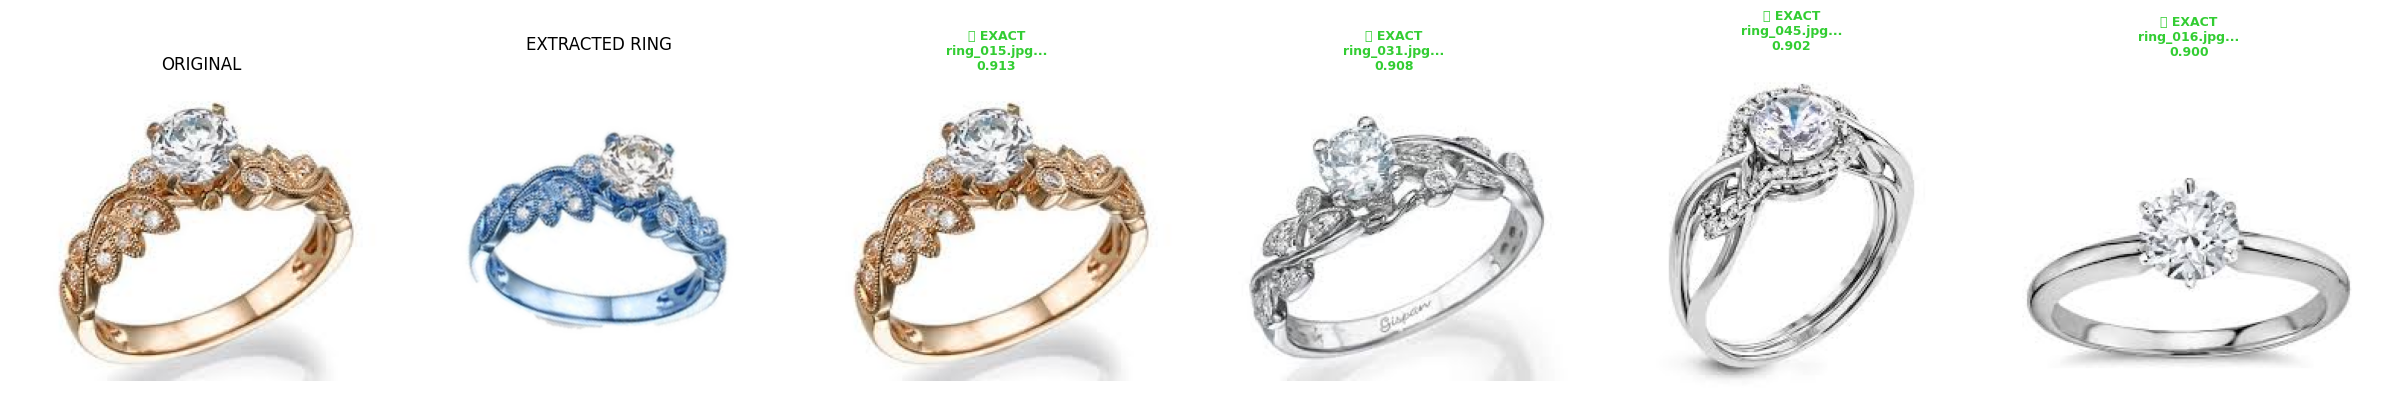

✅ Matching complete.


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import numpy as np
from PIL import Image
from google.colab import files
import os, shutil
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ===============================
# LOAD YOLO
# ===============================
yolo_model = YOLO("yolo11m.pt")
print("✅ YOLO model loaded.")

# ===============================
# ROTATION UTILITY
# ===============================
def rotate_image_pil(img, angle):
    return img.rotate(angle, expand=True, fillcolor=(255,255,255))
def fallback_center_crop(image_path):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    s = int(min(w, h) * 0.6)

    cx, cy = w // 2, h // 2
    crop = img.crop((cx - s//2, cy - s//2, cx + s//2, cy + s//2))

    canvas = Image.new("RGB", (512, 512), (255,255,255))
    crop = crop.resize((400,400), Image.LANCZOS)
    canvas.paste(crop, ((512-400)//2, (512-400)//2))
    return canvas
#Function for clean images
def is_clean_catalog_image(pil_img):

    img = np.array(pil_img.convert("RGB"))
    h, w, _ = img.shape

    # --- 1️⃣ Background whiteness ---
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    white_ratio = np.mean(gray > 240)  # near-white pixels

    # --- 2️⃣ Skin color detection (HSV) ---
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    skin_mask = cv2.inRange(
        hsv,
        (0, 20, 70),    # lower skin HSV
        (20, 255, 255)  # upper skin HSV
    )
    skin_ratio = np.mean(skin_mask > 0)

    # --- 3️⃣ Object coverage (ring size) ---
    _, thresh = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV)
    object_ratio = np.mean(thresh > 0)

    print(
        f"🧪 white={white_ratio:.2f}, "
        f"skin={skin_ratio:.4f}, "
        f"object={object_ratio:.2f}"
    )

    # --- Decision ---
    if white_ratio > 0.55 and skin_ratio < 0.005 and object_ratio < 0.6:
        return True

    return False
# ===============================
# ROTATION-INVARIANT MATCHING (FIXED)
# ===============================
def rotation_invariant_matching(query_embs, db_embs, top_k=5, threshold=0.65):
    """
    True rotation-invariant cosine matching.
    Assumes ALL embeddings are L2-normalized.
    """
    sims = cosine_similarity(query_embs, db_embs)   # (R, N)
    best_sim = sims.max(axis=0)                      # best rotation per DB

    idx = np.where(best_sim >= threshold)[0]
    idx = idx[np.argsort(best_sim[idx])[::-1]]

    return idx[:top_k], best_sim[idx[:top_k]]

# ===============================
# MAIN PIPELINE
# ===============================
print("\n🗑️ Clearing previous data...")
upload_folder = "/content/ring_matcher/data/uploads"
if os.path.exists(upload_folder):
    shutil.rmtree(upload_folder)
os.makedirs(upload_folder, exist_ok=True)

print("--- UPLOAD YOUR RING IMAGE ---")
uploaded = files.upload()
if len(uploaded) != 1:
    raise ValueError("Upload exactly ONE image")

file_name = list(uploaded.keys())[0]
query_path = os.path.join(upload_folder, file_name)
shutil.move(file_name, query_path)

print(f"✅ Query image: {file_name}")

# ===============================
# PROCESS QUERY
# ===============================

original_img = Image.open(query_path).convert("RGB")

if is_clean_catalog_image(original_img):
    print("🟢 Clean ring detected — skipping extraction")
    extracted_pil = original_img

else:
    print("🟠 Hand image detected — extracting ring")
    extracted_pil = extract_actual_ring(
        query_path, predictor, realesrgan_model, yolo_model
    )

    if extracted_pil is None:
        print("⚠️ Ring extraction failed — using fallback crop")
        extracted_pil = fallback_center_crop(query_path)

# ===============================
# EMBEDDINGS (IMPORTANT FIX)
# ===============================
print("🧠 Computing rotation-invariant embeddings...")

# 🔑 THESE ANGLES ARE CORRECT (8 was harmful)
angles = [0, 60, 120, 180]

query_embs = []
for a in angles:
    rot = rotate_image_pil(extracted_pil, a)
    emb = get_embedding(rot).astype(np.float32)
    emb /= np.linalg.norm(emb) + 1e-8   # ✅ CRITICAL
    query_embs.append(emb)

query_embs = np.vstack(query_embs)

# normalize DB embeddings ONCE
db_embs = db_embs.astype(np.float32)
db_embs /= np.linalg.norm(db_embs, axis=1, keepdims=True) + 1e-8

# ===============================
# MATCHING
# ===============================
print("🔗 Matching against database...")
top_indices, scores = rotation_invariant_matching(
    query_embs, db_embs, top_k=4, threshold=0.65
)

# ===============================
# VISUALIZATION
# ===============================
plt.figure(figsize=(24,4))

plt.subplot(1,6,1)
plt.imshow(original_img)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(1,6,2)
plt.imshow(extracted_pil)
plt.title("EXTRACTED RING")
plt.axis("off")

for i, idx in enumerate(top_indices):
    match_img = Image.open(os.path.join(db_folder, db_images[idx])).convert("RGB")
    score = scores[i]

    plt.subplot(1,6,i+3)
    plt.imshow(match_img)

    if score >= 0.85:
        label = "✅ EXACT"
        color = "limegreen"
    elif score >= 0.75:
        label = "🔥 VERY SIMILAR"
        color = "gold"
    else:
        label = "👥 SIMILAR"
        color = "orange"

    plt.title(f"{label}\n{db_images[idx][:18]}...\n{score:.3f}",
              fontsize=9, color=color, fontweight="bold")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("✅ Matching complete.")